In [120]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


In [121]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shivamb/real-or-fake-fake-jobposting-prediction")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/real-or-fake-fake-jobposting-prediction


In [122]:
df= pd.read_csv("/root/.cache/kagglehub/datasets/shivamb/real-or-fake-fake-jobposting-prediction/versions/1/fake_job_postings.csv")
df.head()


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [123]:
df.shape

(17880, 18)

In [124]:
df=df[[
    'company_profile', 'description', 'requirements', 'benefits',
    'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent'
]]
df.head()

,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,fraudulent
0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,0
1,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,0
2,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,0
3,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,0
4,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,0


In [125]:
df.shape

(17880, 8)

In [126]:
df['text'] = df[['company_profile', 'description', 'requirements', 'benefits']].fillna('').agg(' '.join, axis=1)
df = df.drop(['company_profile', 'description', 'requirements', 'benefits'],axis=1)
df.head()



,telecommuting,has_company_logo,has_questions,fraudulent,text
0,0,1,0,0,"We're Food52, and we've created a groundbreaki..."
1,0,1,0,0,"90 Seconds, the worlds Cloud Video Production ..."
2,0,1,0,0,Valor Services provides Workforce Solutions th...
3,0,1,0,0,Our passion for improving quality of life thro...
4,0,1,1,0,SpotSource Solutions LLC is a Global Human Cap...


In [127]:
df.isnull().sum()

,0
telecommuting,0
has_company_logo,0
has_questions,0
fraudulent,0
text,0


In [128]:
df['fraudulent'].value_counts()

,count
fraudulent,
0,17014
1,866


In [129]:
frd_0 = df[df["fraudulent"]==0]
frd_1 = df[df["fraudulent"]==1]
frd_sample= frd_0.sample(n=900)
df = pd.concat([frd_sample,frd_1],axis=0)
df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,text
13197,0,0,0,0,POSITION OBJECTIVE: ...
9347,0,1,0,0,Cohaesus is a trusted partner to the world's g...
15844,0,1,0,0,About the Company:EventBoard (#URL_d92e566922...
14452,0,1,1,0,#URL_a397afc00bff956382eec8b3826bbd79bd4cbade1...
41,0,1,1,0,We help teachers get safe &amp; secure jobs ab...


In [130]:
# Vectorize text
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
X_text = tfidf.fit_transform(df['text']).toarray() # .toarray() convert X_text from
# sparse matrix(sparse matrix is a matrix that contains mostly zeros and only a few non-zero values.) to a numpy array
# Useful later in stacking

# Add binary features
X_binary = df[['telecommuting', 'has_company_logo', 'has_questions']].values

# Combine all features
X = np.hstack((X_binary, X_text))



In [131]:
print(X)


[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.0528362  0.         0.03831651]
 [0.         1.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.08383806 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]]


In [132]:
X.shape

(1766, 503)

In [133]:
y= df["fraudulent"]


In [134]:
y.shape

(1766,)

In [135]:
print(X)
print(y)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.0528362  0.         0.03831651]
 [0.         1.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.08383806 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]]
13197    0
9347     0
15844    0
14452    0
41       0
        ..
17827    1
17828    1
17829    1
17830    1
17831    1
Name: fraudulent, Length: 1766, dtype: int64


In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [137]:
#training
model_sklearn = LogisticRegression()
model_sklearn.fit(X_train,y_train)


LogisticRegression()

In [138]:
#Evaluating
y_prd_sklearn = model_sklearn.predict(X_test)
accuracy = accuracy_score(y_test,y_prd_sklearn)# used accuracy because the data is balanced since I did undersampling
print("The accuracy is ",accuracy)

The accuracy is  0.8954802259887006


#Now I'm going to use a Logistic regression from scratch and try and compare the accuracy between the two models

In [139]:
class Logistic_Regression():


  # declaring learning rate & number of iterations (Hyperparametes)
  def __init__(self, learning_rate, no_of_iterations):

    self.learning_rate = learning_rate
    self.no_of_iterations = no_of_iterations



  # fit function to train the model with dataset
  def fit(self, X, Y):

    # number of data points in the dataset (number of rows)  -->  m
    # number of input features in the dataset (number of columns)  --> n
    self.m, self.n = X.shape


    #initiating weight & bias value

    self.w = np.zeros(self.n)

    self.b = 0

    self.X = X

    self.Y = Y


    # implementing Gradient Descent for Optimization

    for i in range(self.no_of_iterations):
      self.update_weights()



  def update_weights(self):

    # Y_hat formula (sigmoid function)

    Y_hat = 1 / (1 + np.exp( - (self.X.dot(self.w) + self.b ) ))


    # derivaties

    dw = (1/self.m)*np.dot(self.X.T, (Y_hat - self.Y))

    db = (1/self.m)*np.sum(Y_hat - self.Y)


    # updating the weights & bias using gradient descent

    self.w = self.w - self.learning_rate * dw

    self.b = self.b - self.learning_rate * db


  # Sigmoid Equation & Decision Boundary

  def predict(self, X):

    Y_pred = 1 / (1 + np.exp( - (X.dot(self.w) + self.b ) ))
    Y_pred = np.where( Y_pred > 0.5, 1, 0)
    return Y_pred

In [140]:
model_scratch = Logistic_Regression(learning_rate=0.001, no_of_iterations=1000)
model_scratch.fit(X_train,y_train)

In [141]:
#Evaluating
y_prd_scratch = model_scratch.predict(X_test)
accuracy = accuracy_score(y_test,y_prd_scratch)# used accuracy because the data is balanced since I did undersampling
print("The accuracy is ",accuracy)

The accuracy is  0.7655367231638418


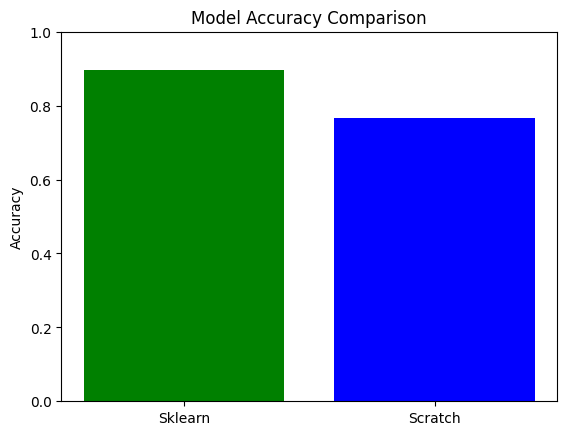

In [142]:


accuracies = [accuracy_score(y_test, y_prd_sklearn),
              accuracy_score(y_test, y_prd_scratch)]

labels = ['Sklearn', 'Scratch']

plt.bar(labels, accuracies, color=['green', 'blue'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()
